In [111]:
from k_seq.data import filters
reload(filters)

<module 'k_seq.data.filters' from '/home/yuning/research/k-seq/src/pkg/k_seq/data/filters.py'>

In [93]:
spike_in_filter = filters.SpikeInFilter(target=byo_doped_table)
spike_in_filter.summary()

,unique,unique_passed,total,total_passed
A1,366471,366471,12808719,12808719
A2,324369,324369,12528391,12528391
A3,514251,514251,26534366,26534366
B1,180803,180803,11820568,11820568
B2,188013,188013,13334445,13334445
B3,168492,168492,12090627,12090627
C1,276163,276163,9516938,9516938
C2,185372,185372,10178038,10178038
C3,200071,200071,11247585,11247585
D1,435084,435084,13318223,13318223


In [105]:
seq_length_filter = filters.SeqLengthFilter(target=byo_doped_table, min_len=21, max_len=21)

In [106]:
seq_length_filter.summary()

,unique,unique_passed,total,total_passed
A1,366471,290866,12808719,12424891
A2,324369,258704,12528391,12172314
A3,514251,403588,26534366,25775801
B1,180803,144242,11820568,11557233
B2,188013,149987,13334445,13046006
B3,168492,134263,12090627,11818575
C1,276163,219466,9516938,9285494
C2,185372,147609,10178038,9965328
C3,200071,159508,11247585,11022884
D1,435084,342290,13318223,12964895


In [70]:
from k_seq.data import transform
reload(transform)

byo_doped_table.metadata.spike_in = transform.SpikeInNormalizer(
    spike_in_seq='AAAAACAAAAACAAAAACAAA',
    spike_in_amount=np.concatenate((
                    np.repeat([2, 2, 1, 0.2, .04], repeats=3),
                    np.array([10/3])), axis=0
                ),
    radius=4,
    target=byo_doped_table
)

In [113]:
sing_filter = filters.SingletonFilter(target=byo_doped_table)

In [114]:
sing_filter.summary()

,unique,unique_passed,total,total_passed
A1,366471,280716,12808719,12722964
A2,324369,251837,12528391,12455859
A3,514251,376303,26534366,26396418
B1,180803,149694,11820568,11789459
B2,188013,155533,13334445,13301965
B3,168492,140257,12090627,12062392
C1,276163,218899,9516938,9459674
C2,185372,153070,10178038,10145736
C3,200071,163767,11247585,11211281
D1,435084,326904,13318223,13210043


## Compare to pool design

Convert to a doped_pool.py

In [139]:
from k_seq.data import landscape
reload(landscape)

pool_peaks = {
    'pk2': 'ATTACCCTGGTCATCGAGTGA',
    'pk1A': 'CTACTTCAAACAATCGGTCTG',
    'pk1B': 'CCACACTTCAAGCAATCGGTC',
    'pk3': 'AAGTTTGCTAATAGTCGCAAG'
}

pool_peaks = [landscape.Peaks(target=byo_table, center_seq=seq, name=name, radius=5)
              for name, seq in pool_peaks.items()]

In [141]:
mega_peak = landscape.Peaks.from_peak_list(pool_peaks)

In [155]:
pool_peaks[0].peak_abun(max_radius=5)[['A1', 'A2', 'A3']]

,A1,A2,A3
0,0.096184,0.089109,0.091955
1,0.171135,0.154632,0.157799
2,0.199262,0.179027,0.181491
3,0.209968,0.188294,0.190260
4,0.213991,0.191814,0.193514
5,0.215317,0.192954,0.194560


In [188]:
def peak_abun_plot(peak, max_radius, rel_abun_table=None, sample_grouper=None, sample_plot_kwargs=None, ax=None, save_fig_to=None):
    peak_abun_info = peak.peak_abun(max_radius=max_radius,
                                        rel_abun_table=rel_abun_table)
    
    if sample_grouper is not None:
        peak_abun_info = pd.DataFrame.from_dict(
            {x_val: peak_abun_info[group].mean(axis=1)
             for x_val, group in sample_grouper.items()},
            orient='columns'
        )
        
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=[8, 6])
    if sample_plot_kwargs is None:
        from k_seq.utility.plot_tools import PlotPreset
        colors = PlotPreset.colors(num=len(peak_abun_info.columns))
        markers = PlotPreset.markers(num=len(peak_abun_info.columns), with_line=False)
        sample_plot_kwargs = {
            sample: {'color': color,
                     'marker': marker}
            for sample, color, marker in zip(peak_abun_info.columns, colors, markers)
        }
    loc = np.arange(0, max_radius + 1)
    for sample in peak_abun_info.columns:
        ax.plot(loc, peak_abun_info[sample], ls='-', markeredgewidth=2, **sample_plot_kwargs[sample], label=sample)
        
    ax.set_ylabel('Relative abundance', fontsize=14)
    ax.set_xlabel('Peak radius (edit distance)', fontsize=14)
    ax.tick_params(labelsize=12)
    ax.text(s=peak.name, x=0, y=ax.get_ylim()[1] * 0.9, fontsize=18, color='#151515')
    
    if save_fig_to:
        fig.savefig(save_fig_to, bbox_inches='tight', dpi=300)

/home/yuning/research/k-seq/src/pkg/k_seq/data/landscape.py:57: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


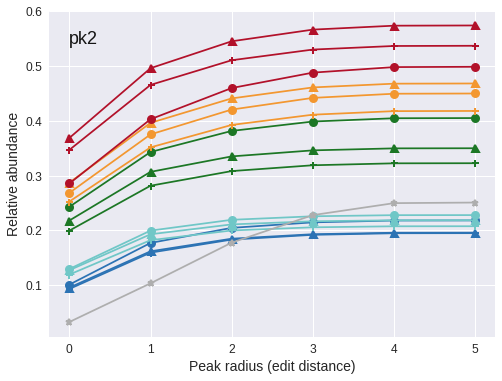

In [189]:
sample_plot_kwargs = {
    'R0': {'color': '#AEAEAE', 'marker': '*'}
}

color_list = ['#2C73B4', '#70C7C7', '#1C7725', '#F39730', '#B2112A']
marker_list = ['o', '+', '^']

for byo, color in zip(['A', 'B', 'C', 'D', 'E'], color_list):
    for rep, marker in zip(['1', '2', '3'], marker_list):
        sample_plot_kwargs[byo + rep] = {'color': color, 'marker': marker}
        
peak_abun_plot(peak=pool_peaks[0], max_radius=5, sample_plot_kwargs=sample_plot_kwargs, rel_abun_table=byo_table.filtered_rel_abun)

/home/yuning/research/k-seq/src/pkg/k_seq/data/landscape.py:57: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


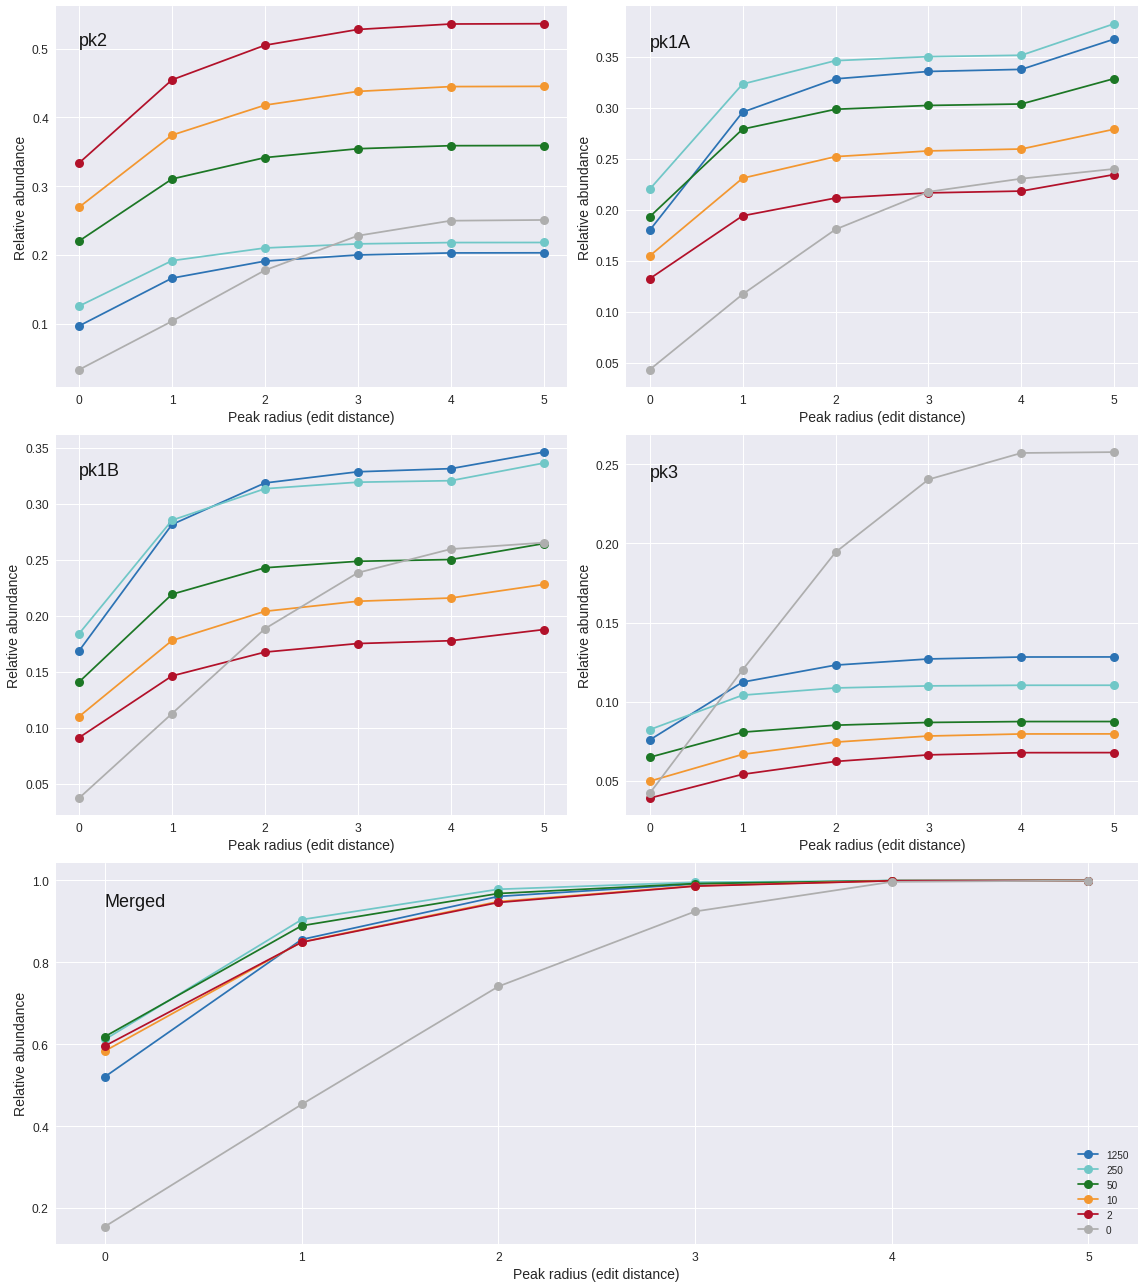

In [192]:
fig = plt.figure(figsize=[16, 18], constrained_layout=False)
gs = fig.add_gridspec(3, 2)

sample_grouper = {
    1250: ['A1', 'A2', 'A3'],
    250: ['B1', 'B2', 'B3'],
    50: ['C1', 'C2', 'C3'],
    10: ['D1', 'D2', 'D3'],
    2: ['E1', 'E2', 'E3'],
    0: ['R0']
}

axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2, :])
]


sample_plot_kwargs = {
    1250: {'color': '#2C73B4', 'marker': 'o', 'alpha': 1},
    250: {'color': '#70C7C7', 'marker': 'o', 'alpha': 1},
    50: {'color': '#1C7725', 'marker': 'o', 'alpha': 1},
    10: {'color': '#F39730', 'marker': 'o', 'alpha': 1},
    2: {'color': '#B2112A', 'marker': 'o', 'alpha': 1},
    0: {'color': '#AEAEAE', 'marker': 'o', 'alpha': 1},
}
        
peak_list = pool_peaks + [landscape.Peaks.from_peak_list(pool_peaks)]
peak_list[-1].name = 'Merged'

for peak, ax in zip(peak_list, axes):
    peak_abun_plot(peak=peak, max_radius=5, sample_grouper=sample_grouper,
                   sample_plot_kwargs=sample_plot_kwargs,
                   rel_abun_table=byo_table.filtered_rel_abun, ax=ax)
axes[-1].legend(loc='lower right')
plt.tight_layout()
plt.show()

In [178]:
def peak_abun_kin_plot(peak, max_radius, sample_grouper, rel_abun_table=None, sample_plot_kwargs=None, ax=None, save_fig_to=None):
    peak_abun_info = peak.peak_abun(max_radius=max_radius,
                                    rel_abun_table=rel_abun_table)
    
    peak_abun_kin_info = pd.DataFrame.from_dict(
        {x_val: peak_abun_info[group].mean(axis=1)
         for x_val, group in sample_grouper.items()},
        orient='index'
    )
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=[8, 6])
        
    if sample_plot_kwargs is None:
        from k_seq.utility.plot_tools import PlotPreset
        colors = PlotPreset.colors(num=len(peak_abun_kin_info.columns))
        markers = PlotPreset.markers(num=len(peak_abun_kin_info.columns), with_line=False)
        sample_plot_kwargs = {
            sample: {'color': color,
                     'marker': marker}
            for sample, color, marker in zip(peak_abun_kin_info.columns, colors, markers)
        }
        
    loc = peak_abun_kin_info.index
    
    for dist in peak_abun_kin_info.columns:
        ax.plot(loc, peak_abun_kin_info[dist], ls='-', markeredgewidth=2, **sample_plot_kwargs[dist], label=f'dist = {dist}')
        
    ax.set_ylabel('Relative abundance', fontsize=14)
    ax.set_xlabel('BYO concentration', fontsize=14)
    ax.tick_params(labelsize=12)
    ylims = ax.get_ylim()
    ax.set_ylim([ylims[0], ylims[1] * 1.2])
    ax.text(s=peak.name, x=0, y=ylims[1] * 1.1, fontsize=18, color='#151515')
    
    if save_fig_to:
        fig.savefig(save_fig_to, bbox_inches='tight', dpi=300)

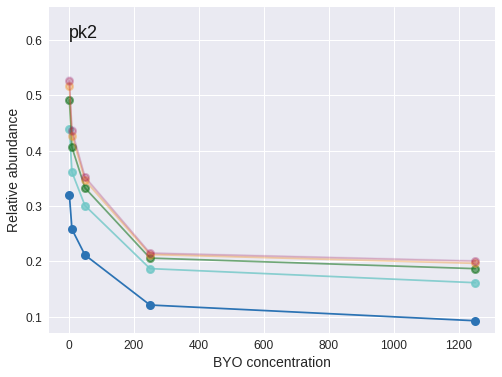

In [179]:
peak_abun_kin_plot(peak_list[0], max_radius=5, sample_grouper=sample_grouper, sample_plot_kwargs=sample_plot_kwargs)

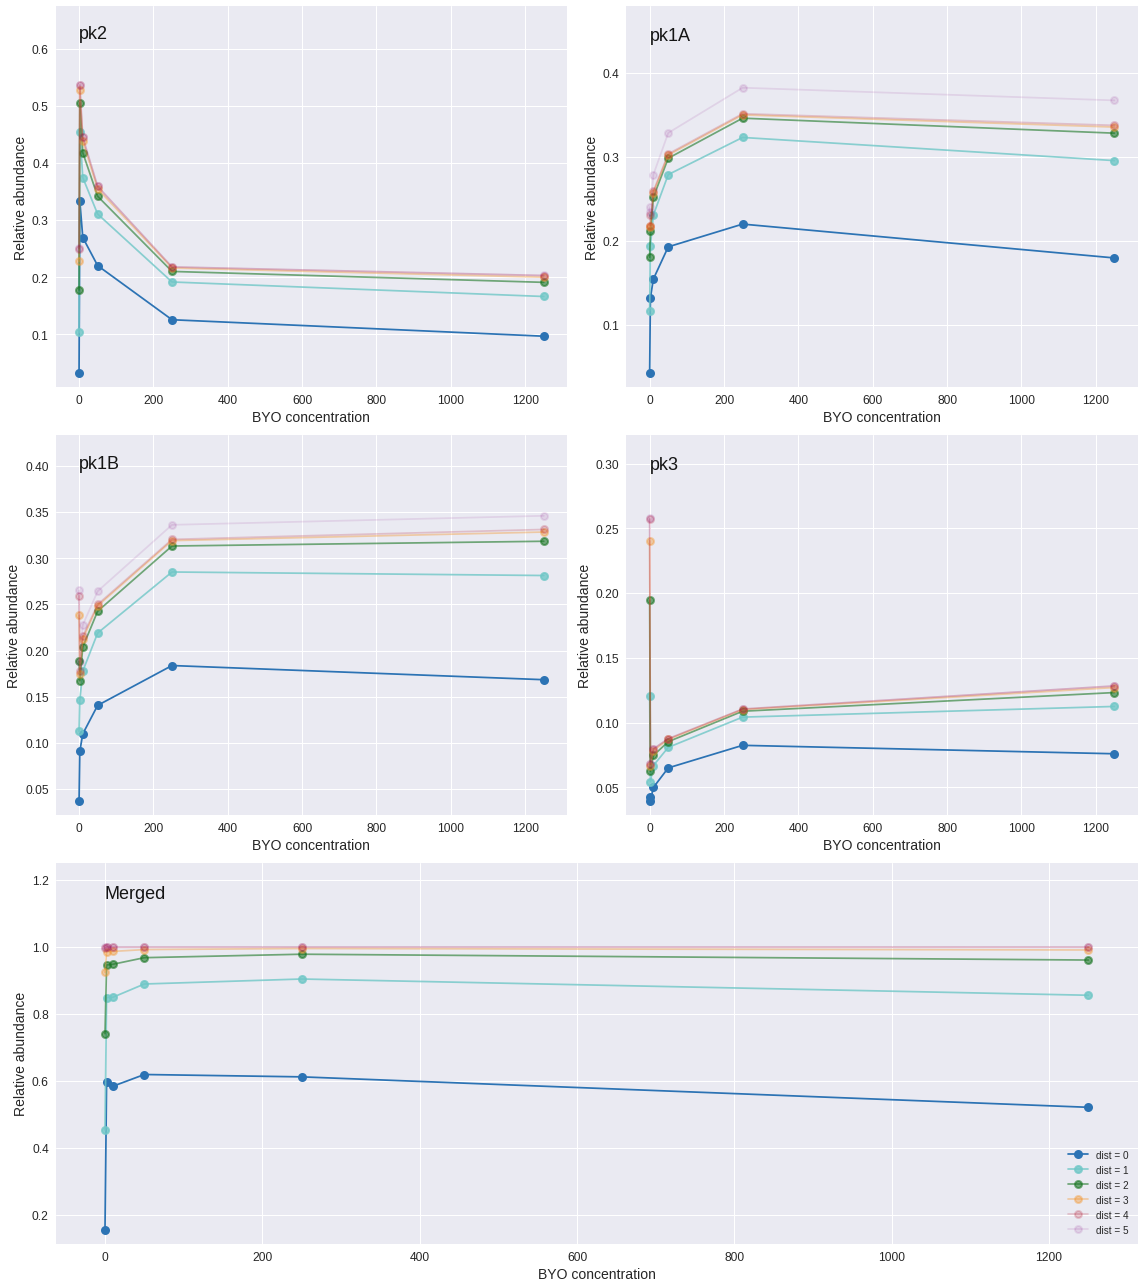

In [185]:
sample_grouper = {
    1250: ['A1', 'A2', 'A3'],
    250: ['B1', 'B2', 'B3'],
    50: ['C1', 'C2', 'C3'],
    10: ['D1', 'D2', 'D3'],
    2: ['E1', 'E2', 'E3'],
    0: ['R0']
}

sample_plot_kwargs = {
    0: {'color': '#2C73B4', 'marker': 'o', 'alpha': 1},
    1: {'color': '#70C7C7', 'marker': 'o', 'alpha': 0.8},
    2: {'color': '#1C7725', 'marker': 'o', 'alpha': 0.6},
    3: {'color': '#F39730', 'marker': 'o', 'alpha': 0.4},
    4: {'color': '#B2112A', 'marker': 'o', 'alpha': 0.2},
    5: {'color': '#810080', 'marker': 'o', 'alpha': 0.1},
}

fig = plt.figure(figsize=[16, 18], constrained_layout=False)
gs = fig.add_gridspec(3, 2)
axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2, :])
]
        
peak_list = pool_peaks + [landscape.Peaks.from_peak_list(pool_peaks)]
peak_list[-1].name = 'Merged'

for peak, ax in zip(peak_list, axes):
    peak_abun_kin_plot(peak=peak, max_radius=5,
                       sample_grouper=sample_grouper,
                       sample_plot_kwargs=sample_plot_kwargs,
                       rel_abun_table=byo_table.filtered_rel_abun, ax=ax)
axes[-1].legend()
plt.tight_layout()
plt.show()

In [343]:
func_tools.dict_flatten(pd.DataFrame(data=[[0, 1], [3, 1]], index=['ix1', 'ix2'], columns=['col1', 'col2']).to_dict())

{'col1_ix1': 0, 'col1_ix2': 3, 'col2_ix1': 1, 'col2_ix2': 1}

In [308]:
test_series = pd.Series(data=[0, 1, 2, 3, 4], index=[0, 1, 2, 3, 4])

In [347]:
np.full(fill_value=np.nan, shape=(2))

array([nan, nan])

# load results from pod_run

In [3]:
from k_seq.utility import file_tools
reload(file_tools)

<module 'k_seq.utility.file_tools' from '/home/yuning/research/k-seq/src/pkg/k_seq/utility/file_tools.py'>

In [60]:
point_est_res = pd.read_csv('/mnt/storage/projects/k-seq/working/byo_doped/least_square/pod-run_10-21/bs-0_mtd-pct_res_c-40/fit_summary.csv', index_col=0)

In [43]:
point_est_res

,k,A
CTACTTCAAACAATCGGTCTG,209.576805,0.419282
CCACACTTCAAGCAATCGGTC,155.360038,0.455281
ATTACCCTGGTCATCGAGTGA,679.435538,0.287239
AAGTTTGCTAATAGTCGCAAG,164.256725,0.176522
GTACTTCAAACAATCGGTCTG,169.874871,0.306387
...,...,...
CCTCACTTCAAGCCATTGATC,0.020391,0.032159
AAGTTTGCTAATGGCTGCAAA,0.020391,0.032159
CCACACCTCAACCAATCTGCC,0.010577,0.049764
CGACCTCAAACAACCGGTCAG,0.020391,0.032159


In [10]:
def single_to_json(single):
    import json
    
    data_to_json = {
        'fitter': None,
        'point_estimation': {
                'params': single.results.point_estimation.summary.to_json(),
                'pcov': None
            }
    }
    if single.results.uncertainty is None:
        data_to_json['uncertainty'] = {'summary': None, 'record': None}
    else:
        data_to_json['uncertainty'] = {
            'summary': single.results.uncertainty.summary.to_json(),
            'record': single.results.uncertainty.record.to_json()
        }
    return json.dumps(data_to_json)
                
                
def batch_to_json(batch, path=None):
    """Save fitting results as a JSON file
    Structure:

      - fitter: a string representation of the fitter

      - record: {seq: JSON of single fitter results}

    """
    import json
    data_to_json = {
        'fitter': None,
        'record': {seq: single_to_json(result) for seq, result in batch.results.results.items()}
    }

    if path is None:
        return json.dumps(data_to_json)
    else:
        with open(path, 'w') as handle:
            json.dump(data_to_json, handle)

In [11]:
batch_to_json(batch=point_est_res, path='/mnt/storage/projects/k-seq/working/byo_doped/least_square/fitter_bs0_mpct_res_c40_converted_from_pickle.json')

In [12]:
top10000_bs = file_tools.read_pickle('/mnt/storage/projects/k-seq/working/byo_doped/least_square/pod_run_10-19/fitter_bs500_mdata_c40.pkl')

In [14]:
batch_to_json(batch=top10000_bs, path='/mnt/storage/projects/k-seq/working/byo_doped/least_square/pod_run_10-19/fitter_bs500_mdata_c40_converted_from_pickle.json')

In [100]:
top10000_bs.results.results['CTACTTCAAACAATCGGTCTG'].results.uncertainty.summary

,k,A
count,500.000000,500.000000
mean,214.048474,0.426293
std,61.041640,0.068560
min,92.160185,0.271777
2.5%,100.960918,0.324562
50%,212.873462,0.417733
97.5%,322.902732,0.595835
max,414.589583,0.602357


In [5]:
def get_fitter():

    def load_table(table_path):
        from pathlib import Path
        table_path = Path(table_path)
        import pickle
        with open(table_path, 'rb') as handle:
            table = pickle.load(handle)
        return table
    
    from k_seq.estimator.least_square import BatchFitter
    from k_seq.model.kinetic import BYOModel

    # todo: make it CL tool using argparse
    seq_table = load_table(table_path=TABLE_PATH)
    if TEST_MODE:
        seq_test = seq_table.reacted_frac_filtered.index.values[:100]
    else:
        seq_test = None

    batch_fitter = BatchFitter(table=seq_table.reacted_frac_filtered, x_values=seq_table.x_values, model=BYOModel.func_react_frac_no_slope, seq_to_fit=seq_test, bootstrap_num=BS_NUM, bs_return_num=BS_SAVE_NUM, bs_method=BS_METHOD)
    
    return batch_fitter

In [10]:
from k_seq.estimator import least_square
reload(least_square)

TABLE_PATH = '/mnt/storage/projects/k-seq/datasets/byo_doped.pkl'
PKG_PATH = '.'
TEST_MODE = False
CORE_NUM = 40
BS_NUM = 0
BS_SAVE_NUM = 0
BS_METHOD = 'pct_res'

point_est = get_fitter()

In [70]:
abe_res = pd.read_csv('/mnt/storage/projects/k-seq/datasets/byo_on_abes_method/allseqs-name-fit_repeat.csv', index_col='X')[2:]
abe_res

,Abun R5c-counts.txt,L by avg,k by avg,L stdev,k stdev
X,,,,,
GGGGGGAGAAGTTAATGG,0.000191,0.999411,50.765753,0.000000,0.000000
GGGGGAAATGTCAGGTCATGC,0.000191,0.337199,0.674452,0.007564,0.015246
GGGGGAAATTCCAAGGTCATG,0.000191,0.975867,14.310327,0.314230,39.507303
GGGGGAATCCTACGTGTCAAG,0.000191,0.710566,3.027453,0.294333,4.993080
GGGGGAACCGGGTGGCCCCGA,0.000191,0.337198,0.674450,0.007562,0.015242
...,...,...,...,...,...
CCCCC,0.000382,0.337199,0.674452,0.007564,0.015246
CCCC,0.000382,0.999564,55.043066,0.001454,22.233369
CCC,0.002290,0.993262,23.779244,0.009470,17.871010


In [62]:
common_seq = list(set(abe_res.index) & set(point_est_res.index))
print(len(common_seq))

4278


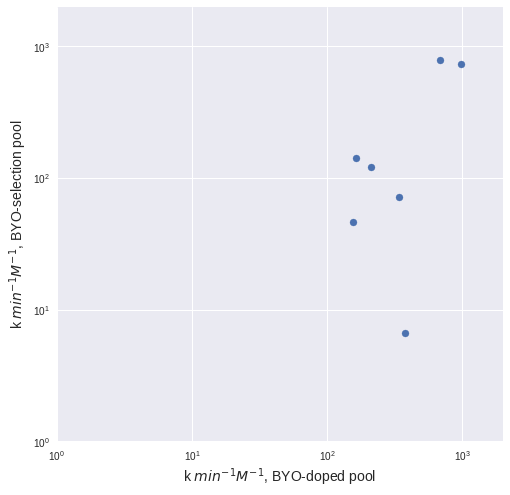

In [54]:
# selected sequences with gel shift results

selected_seqs = {
    'S-2.1-a': ('ATTACCCTGGTCATCGAGTGA', 779, 0.161),
    'S-2.1-t': ('ATTACCCTGGTCATCGAGTGT', 729, 0.158),
    'S-1A.1-a': ('CTACTTCAAACAATCGGTCTG', 121, 0.283),
    'S-1B.1-a': ('CCACACTTCAAGCAATCGGTC', 46.2, 0.865),
   # 'S-1B.2-a': ('CCGCTTCAAGCAATCGGTCGC', 47.3, 0.669),
    'S-1B.3-a': ('CCGAGTTTCAAGCAATCGGTC', 71.2, 0.458),
    'S-3.1-a': ('AAGTTTGCTAATAGTCGCAAG', 142, 0.134),
   # 'S-2.2-a': ('ATTCACCTAGGTCATCGGGTG', 197, 0.132),
   # 'S-1A.1-n': ('CTCTTCAAACAATCGGTCTTC', 74.9, 0.251),
    'S-1C.1-a': ('CTCTTCAATAATCGGTTGCGT', 6.65, 1.000)
}

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
data = np.array([[point_est_res.loc[seq[0]]['k'], seq[1]] for seq in selected_seqs.values()]).T
ax.scatter(data[0], data[1])
ax.set_yscale('log')
ax.set_ylim([1, 2e3])
ax.set_xscale('log')
ax.set_xlim([1, 2e3])
ax.set_xlabel(r'k $min^{-1}M^{-1}$, BYO-doped pool', fontsize=14)
ax.set_ylabel(r'k $min^{-1}M^{-1}$, BYO-selection pool', fontsize=14)

plt.show()

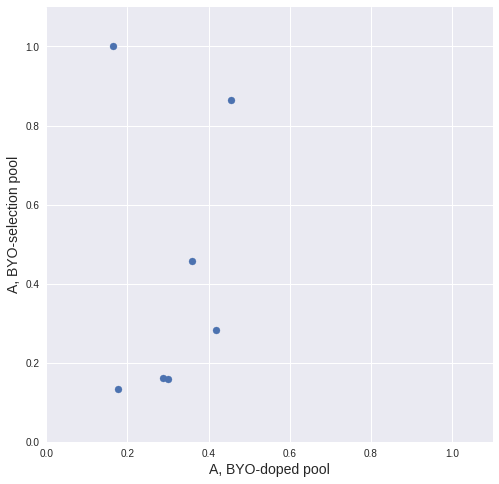

In [57]:
# selected sequences with gel shift results

selected_seqs = {
    'S-2.1-a': ('ATTACCCTGGTCATCGAGTGA', 779, 0.161),
    'S-2.1-t': ('ATTACCCTGGTCATCGAGTGT', 729, 0.158),
    'S-1A.1-a': ('CTACTTCAAACAATCGGTCTG', 121, 0.283),
    'S-1B.1-a': ('CCACACTTCAAGCAATCGGTC', 46.2, 0.865),
   # 'S-1B.2-a': ('CCGCTTCAAGCAATCGGTCGC', 47.3, 0.669),
    'S-1B.3-a': ('CCGAGTTTCAAGCAATCGGTC', 71.2, 0.458),
    'S-3.1-a': ('AAGTTTGCTAATAGTCGCAAG', 142, 0.134),
   # 'S-2.2-a': ('ATTCACCTAGGTCATCGGGTG', 197, 0.132),
   # 'S-1A.1-n': ('CTCTTCAAACAATCGGTCTTC', 74.9, 0.251),
    'S-1C.1-a': ('CTCTTCAATAATCGGTTGCGT', 6.65, 1.000)
}

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
data = np.array([[point_est_res.loc[seq[0]]['A'], seq[2]] for seq in selected_seqs.values()]).T
ax.scatter(data[0], data[1])
# ax.set_yscale('log')
ax.set_ylim([0, 1.1])
# ax.set_xscale('log')
ax.set_xlim([0, 1.1])
ax.set_xlabel(r'A, BYO-doped pool', fontsize=14)
ax.set_ylabel(r'A, BYO-selection pool', fontsize=14)

plt.show()

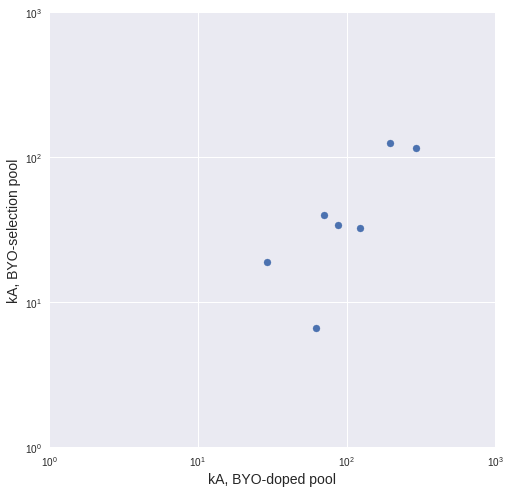

In [58]:
# selected sequences with gel shift results

selected_seqs = {
    'S-2.1-a': ('ATTACCCTGGTCATCGAGTGA', 779, 0.161),
    'S-2.1-t': ('ATTACCCTGGTCATCGAGTGT', 729, 0.158),
    'S-1A.1-a': ('CTACTTCAAACAATCGGTCTG', 121, 0.283),
    'S-1B.1-a': ('CCACACTTCAAGCAATCGGTC', 46.2, 0.865),
   # 'S-1B.2-a': ('CCGCTTCAAGCAATCGGTCGC', 47.3, 0.669),
    'S-1B.3-a': ('CCGAGTTTCAAGCAATCGGTC', 71.2, 0.458),
    'S-3.1-a': ('AAGTTTGCTAATAGTCGCAAG', 142, 0.134),
   # 'S-2.2-a': ('ATTCACCTAGGTCATCGGGTG', 197, 0.132),
   # 'S-1A.1-n': ('CTCTTCAAACAATCGGTCTTC', 74.9, 0.251),
    'S-1C.1-a': ('CTCTTCAATAATCGGTTGCGT', 6.65, 1.000)
}

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
data = np.array([
    [point_est_res.loc[seq[0]]['A'] * point_est_res.loc[seq[0]]['k'], seq[2] * seq[1]] for seq in selected_seqs.values()]).T
ax.scatter(data[0], data[1])
ax.set_yscale('log')
ax.set_ylim([1, 1e3])
ax.set_xscale('log')
ax.set_xlim([1, 1e3])
ax.set_xlabel(r'kA, BYO-doped pool', fontsize=14)
ax.set_ylabel(r'kA, BYO-selection pool', fontsize=14)

plt.show()

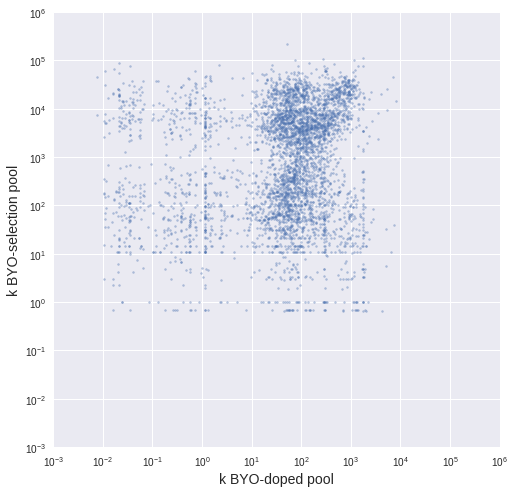

In [69]:
common_seq = list(set(abe_res.index) & set(point_est_res.index))

fig, ax = plt.subplots(1, 1, figsize=[8, 8])

ax.scatter( point_est_res.loc[common_seq]['k'], abe_res.loc[common_seq]['k by avg'], alpha=0.4, s=4)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1e-3, 1e6])
ax.set_ylim([1e-3, 1e6])
ax.set_xlabel(r'k BYO-doped pool', fontsize=14)
ax.set_ylabel(r'k BYO-selection pool', fontsize=14)
plt.show()

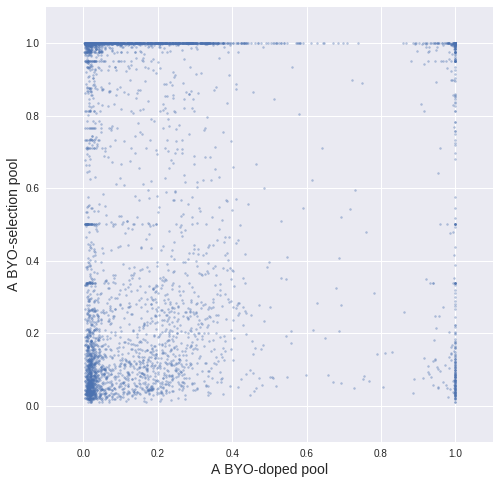

In [65]:
common_seq = list(set(abe_res.index) & set(point_est_res.index))

fig, ax = plt.subplots(1, 1, figsize=[8, 8])

ax.scatter( point_est_res.loc[common_seq]['A'], abe_res.loc[common_seq]['L by avg'], alpha=0.4, s=4)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])
ax.set_xlabel(r'A BYO-doped pool', fontsize=14)
ax.set_ylabel(r'A BYO-selection pool', fontsize=14)
plt.show()

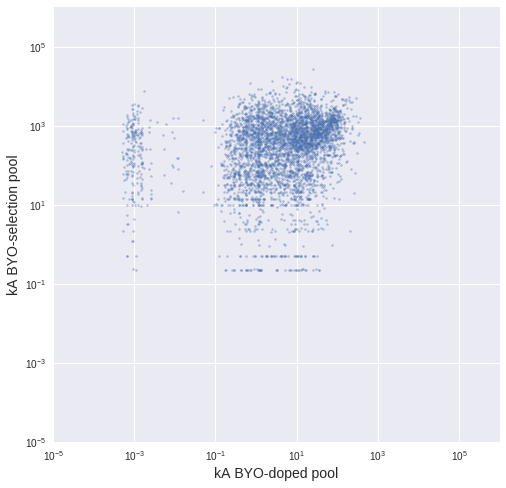

In [71]:
fig, ax = plt.subplots(1, 1, figsize=[8, 8])

ax.scatter(point_est_res.loc[common_seq]['A'] * point_est_res.loc[common_seq]['k'], abe_res.loc[common_seq]['L by avg'] * abe_res.loc[common_seq]['k by avg'], alpha=0.4, s=4)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1e-5, 1e6])
ax.set_ylim([1e-5, 1e6])
ax.set_xlabel(r'kA BYO-doped pool', fontsize=14)
ax.set_ylabel(r'kA BYO-selection pool', fontsize=14)
plt.show()

In [34]:
abe_res.loc[list(common_seq)]

,Abun R5c-counts.txt,L by avg,k by avg,L stdev,k stdev
X,,,,,
ATTGCCCTGGTCATCGGGTGC,0.011639,1.000000,355.617450,3.501477e-08,11.607028
ATTACCCTGGTCATCGGGAGC,0.001717,0.999996,169.388709,7.998141e-02,30.341839
CCGCCCTTCAAAAAATCGGTC,0.004198,1.000000,465.934037,4.113195e-11,32.168270
TATACCCTGGTCATCGAGTAA,0.000191,0.975867,14.310327,3.142302e-01,39.507303
GTAAGCTTCAAGCAATCGGTC,0.003053,0.228315,5831.053610,1.418137e-01,2172.464719
...,...,...,...,...,...
GCAGGCTTCAACCAATCGGTC,0.004579,0.323771,2414.515307,2.663786e-01,575.129690
CCCCACTTCAAGCAATCGTTC,0.000382,0.229867,2125.841041,4.374676e-01,14984.969211
ACAACCCTGGTCATCGAGTGC,0.000191,1.000000,340.973402,1.876912e-06,292.150402


In [43]:
top10000_bs = file_tools.read_pickle('/mnt/storage/projects/k-seq/working/byo_doped/least_square/fitter_bs500_mdata_c40.pkl')

In [11]:
top10000_bs.results.summary()

,k,A,k_mean,k_std,k_2.5%,k_50%,k_97.5%,A_mean,A_std,A_2.5%,A_50%,A_97.5%
CTACTTCAAACAATCGGTCTG,209.582837,0.419280,214.048474,61.041640,100.960918,212.873462,322.902732,0.426293,0.068560,0.324562,0.417733,0.595835
CCACACTTCAAGCAATCGGTC,155.361003,0.455281,166.823291,53.484990,77.591339,162.994980,271.378316,0.488911,0.653414,0.338528,0.441911,0.675208
ATTACCCTGGTCATCGAGTGA,679.436067,0.287238,698.483230,189.350723,376.840645,686.803336,1093.051456,0.287023,0.027097,0.244985,0.284966,0.344741
AAGTTTGCTAATAGTCGCAAG,164.256765,0.176522,169.127548,55.795960,79.465382,164.875313,282.543788,0.182783,0.033944,0.138557,0.176908,0.252731
GTACTTCAAACAATCGGTCTG,169.875897,0.306387,178.590630,54.129192,87.070435,180.373845,279.963793,0.311069,0.055571,0.240873,0.295416,0.435505
...,...,...,...,...,...,...,...,...,...,...,...,...
CTGCTTCAAACAATCAGTCAG,58.663305,0.216556,77.450426,50.647574,11.765385,60.166441,184.408061,0.263782,0.196569,0.108632,0.215297,0.826772
CTACTTCAATTAATCGGTGTG,58.229079,0.080430,62.617822,36.276963,30.764348,57.308761,116.208164,0.083197,0.036178,0.052379,0.081103,0.111105
ATTGTCCTGGTCATCGAGTGG,35.918151,0.114220,40.537949,20.631972,7.294326,37.947933,83.459373,0.150917,0.184650,0.066860,0.109621,0.431392
TGACTTCAAACAATCTGTCTG,62.784885,0.086128,71.468209,33.030280,24.128128,66.921012,141.002844,0.089835,0.029056,0.061739,0.084707,0.158169


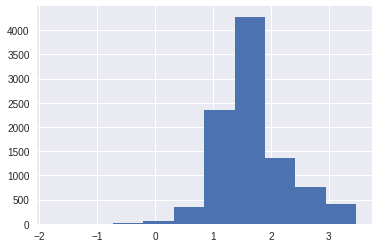

In [15]:
np.log10(top10000_bs.results.summary()['k']).hist()
plt.show()

In [18]:
file_tools.dump_pickle(top10000_bs.results, path='/mnt/storage/projects/k-seq/working/byo_doped/least_square/fitter_bs500_mdata_c40_results.pkl')

In [27]:
top10000_bs.results.results['CTACTTCAAACAATCGGTCTG'].results

In [41]:
import json

bs = top10000_bs.results.results['CTACTTCAAACAATCGGTCTG'].results.uncertainty

In [54]:
test = '/mnt/storage/projects.json'
json.load(test)

AttributeError: 'str' object has no attribute 'read'

In [43]:
def bs_to_json(bs):
    
    data_to_dump = {
        'fitter': str(bs.fitter),
        'bootstrap_num': bs.bootstrap_num,
        'grouper': bs.grouper if hasattr(bs, 'grouepr') else None,
        'method': bs.method,
        'record': bs.record.to_json(),
        'summary': bs.summary.to_json()
    }
    
    return json.dumps(data_to_dump)

In [44]:
bs_json = bs_to_json(bs)

In [46]:
bs_recoverd = json.loads(bs_json)

In [50]:
bs.record

,k,A,x_data,y_data
276,244.687588,0.392767,B1 0.000250 C1 0.000050 B3 0.000250 D...,B1 0.378180 C1 0.153022 B3 0.378988 D...
10,267.530279,0.358241,A1 0.001250 D2 0.000010 B3 0.000250 C...,A1 0.270427 D2 0.029956 B3 0.378988 C...
286,253.537343,0.396468,C1 0.000050 E3 0.000002 A2 0.001250 D...,C1 0.153022 E3 0.005430 A2 0.369641 D...
251,166.327244,0.458186,D3 0.00001 D2 0.00001 C3 0.00005 A3 ...,D3 0.029584 D2 0.029956 C3 0.154642 A...
427,188.851039,0.446624,D2 0.000010 D1 0.000010 E3 0.000002 B...,D2 0.029956 D1 0.030471 E3 0.005430 B...
...,...,...,...,...
446,256.604364,0.353225,E1 0.000002 E2 0.000002 E1 0.000002 C...,E1 0.006454 E2 0.006420 E1 0.006454 C...
109,308.246298,0.351536,E1 0.000002 B1 0.000250 B1 0.000250 E...,E1 0.006454 B1 0.378180 B1 0.378180 E...
182,130.198077,0.515170,E2 0.000002 A3 0.001250 D2 0.000010 A...,E2 0.006420 A3 0.598627 D2 0.029956 A...
95,122.098800,0.583283,E1 0.000002 D1 0.000010 C1 0.000050 C...,E1 0.006454 D1 0.030471 C1 0.153022 C...


In [51]:
pd.read_json(bs_recoverd['summary'])

,k,A
count,500.000000,500.000000
mean,214.048474,0.426293
std,61.041640,0.068560
min,92.160185,0.271777
2.5%,100.960918,0.324562
50%,212.873462,0.417733
97.5%,322.902732,0.595835
max,414.589583,0.602357


In [48]:
bs_recoverd['record']

'{"k":{"276":244.6875875334,"10":267.5302786266,"286":253.5373431621,"251":166.3272444417,"427":188.851039312,"326":232.20996002,"7":184.850769398,"477":253.6026999821,"305":99.7253424185,"392":311.0450105109,"404":212.5769189319,"15":120.1141250263,"39":106.7586940122,"245":317.8007985432,"469":272.2828757736,"444":237.5107289901,"190":218.5859667502,"401":202.2391933997,"196":269.868577242,"284":224.8042858479,"296":202.8323637673,"192":241.7910239202,"90":219.8381944549,"147":128.4572158042,"252":229.5249413271,"384":391.1896872843,"282":139.785298054,"26":263.3440728576,"5":238.7990080505,"229":253.7323024467,"3":255.7191547855,"51":257.1232336584,"341":199.418976893,"0":286.2839680501,"331":248.7302544551,"332":216.9208925777,"349":307.3917932187,"277":101.7744014667,"484":150.539793648,"13":281.6820314344,"481":175.0100798742,"279":176.7704967046,"250":186.5589239029,"354":223.8912356558,"71":111.3390467745,"127":155.8073313132,"179":184.0283752121,"335":249.8407640713,"151":155.

limit_output extension: Maximum message size of 10000 exceeded with 52306 characters

In [31]:
top10000_bs.results

'{"k":{"CTACTTCAAACAATCGGTCTG":209.5828373665,"CCACACTTCAAGCAATCGGTC":155.3610026725,"ATTACCCTGGTCATCGAGTGA":679.4360665063,"AAGTTTGCTAATAGTCGCAAG":164.2567647405,"GTACTTCAAACAATCGGTCTG":169.8758970046,"CTACTTCAATCAATCGGTCTG":105.1980899586,"CCACTCTTCAAGCAATCGGTC":87.1981562049,"TCACACTTCAAGCAATCGGTC":143.6278567591,"CTTCTTCAAACAATCGGTCTG":131.6193772033,"CTACACTTCAAGCAATCGGTC":159.7015277548,"CCTCACTTCAAGCAATCGGTC":161.0185846729,"GCACACTTCAAGCAATCGGTC":126.818853224,"CTACTTCAACCAATCGGTCTG":97.4325356935,"CAACACTTCAAGCAATCGGTC":135.6193965118,"CCACTTCAAACAATCGGTCTG":188.31990688,"TTACTTCAAACAATCGGTCTG":210.2961979576,"ATACTTCAAACAATCGGTCTG":100.2098738156,"CCAAACTTCAAGCAATCGGTC":75.5508231636,"CCATACTTCAAGCAATCGGTC":66.3680115838,"ACACACTTCAAGCAATCGGTC":102.8745778284,"CTAGTTCAAACAATCGGTCTG":42.9217801809,"CCACACTTCAACCAATCGGTC":159.709922452,"CCACACTTCAATCAATCGGTC":134.004244079,"CTCCTTCAAACAATCGGTCTG":206.1514811346,"CCAGACTTCAAGCAATCGGTC":113.4294938042,"ATTACCCTGGTCATCGAGTGC":117.

limit_output extension: Maximum message size of 10000 exceeded with 4500159 characters